In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets.folder import ImageFolder
from torch.utils.data import DataLoader

import os, time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 요부분은 빼셔도 됩니다.
# 제 local PC에서 matplotlib 사용시 커널이 죽는 문제가 있어서 사용하는 부분입니다.
# 문제가 발생하지 않는 분들은 빼도 됩니다.
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

# Make Custom Dataset
<span style = 'font-size:1.2em;line-height:1.5em'>Pytorch에서 제공하는 torch.utils.data.Dataset을 활용하면 직접 custom dataset을 만들수 있습니다.</span>

```python
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self):
        # 데이터의 전처리를 해주는 부분
        pass
    
    def __len__(self):
        # 데이터셋의 길이. 즉, 총 샘플 갯수를 적어주는 부분
        pass
    
    def __getitem__(self, idx):
        # 데이터 셋에서 index를 받으면 해당 index에 해당하는 샘플을 가져오는 함수
```

## 1. Tabular 형태의 data로 CustomDataset 생성하기

- <span style = 'font-size:1.2em;line-height:1.5em'>이를 활용하여 Tabular 형태의 data도 custom dataset으로 만들수 있습니다.</span>
    - <span style = 'font-size:1.2em;line-height:1.5em'>이를 DataLoader에 전달하면 Mini-batch Generator를 만들수 있게됩니다.</span>

In [3]:
df = pd.read_csv('data/train.csv')
df = df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1)
df = df[~df['Age'].isnull()].reset_index(drop=True)
df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  714 non-null    int64  
 1   Survived     714 non-null    int64  
 2   Pclass       714 non-null    int64  
 3   Age          714 non-null    float64
 4   SibSp        714 non-null    int64  
 5   Parch        714 non-null    int64  
 6   Fare         714 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 39.2 KB


In [5]:
np_array = df.values

In [6]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, to_tensor=True):
        df_y = df['Survived']
        self.y = df_y.values
        
        df_x = df.drop('Survived', axis=1)
        self.x = df_x.values
        
        self.to_tensor = to_tensor
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        data = self.x[idx]
        label = self.y[idx]
        if self.to_tensor:
            data = torch.Tensor(data)
            label = torch.Tensor([label])
        return data, label

In [7]:
my_data = MyDataset(to_tensor=True)

In [8]:
df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


In [9]:
my_loader = DataLoader(my_data, batch_size=5)
for i, (x, y) in enumerate(my_loader):
    print(x)
    print(y)
    break

tensor([[ 1.0000,  3.0000, 22.0000,  1.0000,  0.0000,  7.2500],
        [ 2.0000,  1.0000, 38.0000,  1.0000,  0.0000, 71.2833],
        [ 3.0000,  3.0000, 26.0000,  0.0000,  0.0000,  7.9250],
        [ 4.0000,  1.0000, 35.0000,  1.0000,  0.0000, 53.1000],
        [ 5.0000,  3.0000, 35.0000,  0.0000,  0.0000,  8.0500]])
tensor([[0.],
        [1.],
        [1.],
        [1.],
        [0.]])


## 2. ImageFolder 사용하여 Custom Dataset 생성하기

- <span style = 'font-size:1.2em;line-height:1.5em'>기본적으로 CustomDataset은 1번과 같은 형태로 구축합니다.</span>
- <span style = 'font-size:1.2em;line-height:1.5em'>여러 장의 실제 Image 데이터(.jpg, .bmp) 에 대해서는 위와 같은 방식으로 Custom Dataset을 만드는게 좀 불편합니다.</span>
- <span style = 'font-size:1.2em;line-height:1.5em'>이를 편리하게 만들어 주는 기능 중 하나가 ImageFolder입니다.</span>
- <span style = 'font-size:1.2em;line-height:1.5em'>ImageFolder를 만들기 위해서는 기본적으로 폴더 안에 다음과 같이 Image File들이 들어있어야 합니다.</span>

<img src="imgs/Imagefolder.png" width="800" height="400">

### 이걸 왜 사용할까요?
- <span style = 'font-size:1.2em;line-height:1.5em'>여러분이 사용할 데이터는 지금까지 사용한 MNIST 데이터처럼 묶음으로 되어 있지 않고, 개별 이미지 파일로 되어 있을겁니다.</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'>예시) file1.jpg, file2.jpg,... 요런식으로요.</span>

- <span style = 'font-size:1.2em;line-height:1.5em'>이런 데이터들을 batch단위로 모델에 입력할 때 유용합니다.</span>


In [10]:
transform_dataset = ImageFolder(root='tmp/PetImages',           # image들이 들어있는 root 경로를 지정합니다.
                                transform=transforms.Compose([ 
                                    transforms.Resize((224, 224)), # image size를 224*224로 변환
                                    transforms.ToTensor()       # PIL image data를 pytorch tensor로 변환합니다.
                                ]))

### 몇가지 method 및 속성들을 한번 확인해봅시다.

In [11]:
transform_dataset.__len__()

24998

In [12]:
transform_dataset.classes

['Cat', 'Dog']

In [13]:
transform_dataset.class_to_idx

{'Cat': 0, 'Dog': 1}

In [14]:
transform_dataset.samples

[('tmp/PetImages\\Cat\\0.jpg', 0),
 ('tmp/PetImages\\Cat\\1.jpg', 0),
 ('tmp/PetImages\\Cat\\10.jpg', 0),
 ('tmp/PetImages\\Cat\\100.jpg', 0),
 ('tmp/PetImages\\Cat\\1000.jpg', 0),
 ('tmp/PetImages\\Cat\\10000.jpg', 0),
 ('tmp/PetImages\\Cat\\10001.jpg', 0),
 ('tmp/PetImages\\Cat\\10002.jpg', 0),
 ('tmp/PetImages\\Cat\\10003.jpg', 0),
 ('tmp/PetImages\\Cat\\10004.jpg', 0),
 ('tmp/PetImages\\Cat\\10005.jpg', 0),
 ('tmp/PetImages\\Cat\\10006.jpg', 0),
 ('tmp/PetImages\\Cat\\10007.jpg', 0),
 ('tmp/PetImages\\Cat\\10008.jpg', 0),
 ('tmp/PetImages\\Cat\\10009.jpg', 0),
 ('tmp/PetImages\\Cat\\1001.jpg', 0),
 ('tmp/PetImages\\Cat\\10010.jpg', 0),
 ('tmp/PetImages\\Cat\\10011.jpg', 0),
 ('tmp/PetImages\\Cat\\10012.jpg', 0),
 ('tmp/PetImages\\Cat\\10013.jpg', 0),
 ('tmp/PetImages\\Cat\\10014.jpg', 0),
 ('tmp/PetImages\\Cat\\10015.jpg', 0),
 ('tmp/PetImages\\Cat\\10016.jpg', 0),
 ('tmp/PetImages\\Cat\\10017.jpg', 0),
 ('tmp/PetImages\\Cat\\10018.jpg', 0),
 ('tmp/PetImages\\Cat\\10019.jpg', 0),
 

In [15]:
transform_loader = DataLoader(transform_dataset, 
                              batch_size=16, 
                              shuffle=False)

In [16]:
for i, (x,y) in enumerate(transform_loader):
    print("x.shape: ", x.shape)
    print("y.shape: ", y.shape)
    if i==4:
        break

x.shape:  torch.Size([16, 3, 224, 224])
y.shape:  torch.Size([16])
x.shape:  torch.Size([16, 3, 224, 224])
y.shape:  torch.Size([16])
x.shape:  torch.Size([16, 3, 224, 224])
y.shape:  torch.Size([16])
x.shape:  torch.Size([16, 3, 224, 224])
y.shape:  torch.Size([16])
x.shape:  torch.Size([16, 3, 224, 224])
y.shape:  torch.Size([16])


In [17]:
x[0].shape

torch.Size([3, 224, 224])

In [18]:
tmp = x[0].permute(1,2,0)

In [19]:
tmp = np.array(tmp) # numpy array 타입으로 바꾸기
plt.figure(figsize=(6, 6))
# permute로 이미지의 shape를 다음과 같이 변경합니다
# (height, width, channel)


<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

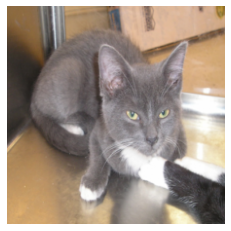

In [20]:

plt.imshow(tmp)
plt.grid(False)
plt.axis('off')
plt.show()